# Проект: ABC/XYZ и RFM анализ продаж одежды через маркетплейсы

---

## Этап 2: ABC-анализ товаров

**Концепция**  
ABC-анализ классифицирует товары по их вкладу в общую выручку:
- **A товары** (обычно ~20% товаров) дают ~80% выручки
- **B товары** (обычно ~30% товаров) дают ~15% выручки
- **C товары** (обычно ~50% товаров) дают ~5% выручки

In [1]:
# загружаю библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
# Настройки визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("Set2")

In [3]:
# загружаю данные (таблица, подготовленная на этапе 1 EDA, с временными столбцами)
df = pd.read_csv('clothing_marketplace_sales_eda.csv')

In [4]:
# Шаг 1: Группировка и расчет выручки по категориям
abc_data = df.groupby('category').agg({
    'order_amount': ['sum', 'count', 'mean'],
    'returned': 'sum'
}).round(2)

# Шаг 2: Сортировка по выручке в убывающем порядке
abc_data = abc_data.sort_values(by=('order_amount', 'sum'), ascending=False)

# Шаг 3: Расчет кумулятивного процента
total_revenue = abc_data[('order_amount', 'sum')].sum()
abc_data['cumulative_pct'] = (
    abc_data[('order_amount', 'sum')].cumsum() / total_revenue * 100
)

# Шаг 4: Присвоение классов A/B/C
def assign_class(pct):
    if pct <= 80:
        return 'A'
    elif pct <= 95:
        return 'B'
    else:
        return 'C'

abc_data['class'] = abc_data['cumulative_pct'].apply(assign_class)

# Шаг 5: Анализ характеристик каждого класса
display(abc_data)
for class_label in ['A', 'B', 'C']:
    class_data = abc_data[abc_data['class'] == class_label]
    print(f"\nКласс {class_label}:")
    print(f"  Категорий товаров: {len(class_data)} ({len(class_data)/len(abc_data)*100:.1f}%)")
    print(f"  Выручка: ₽{class_data[('order_amount', 'sum')].sum():,.0f}")
    print(f"  % от общей выручки: {class_data[('order_amount', 'sum')].sum()/total_revenue*100:.1f}%")
    print(f"  Средний чек: ₽{class_data[('order_amount', 'mean')].mean():,.0f}")
    print(f"  Доля возврата: {class_data[('returned', 'sum')].sum()/class_data[('order_amount', 'count')].sum()*100:.1f}%")

order_amount                 returned cumulative_pct class
                     sum count      mean      sum                     
category                                                              
Outerwear    10805905.50   949  11386.62       78      23.921971     A
Dresses       9339331.61  1211   7712.08      162      44.597261     A
Footwear      8163334.40  1060   7701.26      113      62.669143     A
Bottoms       7168590.31  1423   5037.66      148      78.538874     A
Tops          5082372.24  1571   3235.12      116      89.790163     B
Activewear    2482990.28   618   4017.78       57      95.286974     C
Accessories   1744611.63  1012   1723.92       67      99.149173     C
Intimate       384331.23   156   2463.66       22     100.000000     C


Класс A:
  Категорий товаров: 4 (50.0%)
  Выручка: ₽35,477,162
  % от общей выручки: 78.5%
  Средний чек: ₽7,959
  Доля возврата: 10.8%

Класс B:
  Категорий товаров: 1 (12.5%)
  Выручка: ₽5,082,372
  % от общей выручки: 11.3%
  Средний чек: ₽3,235
  Доля возврата: 7.4%

Класс C:
  Категорий товаров: 3 (37.5%)
  Выручка: ₽4,611,933
  % от общей выручки: 10.2%
  Средний чек: ₽2,735
  Доля возврата: 8.2%


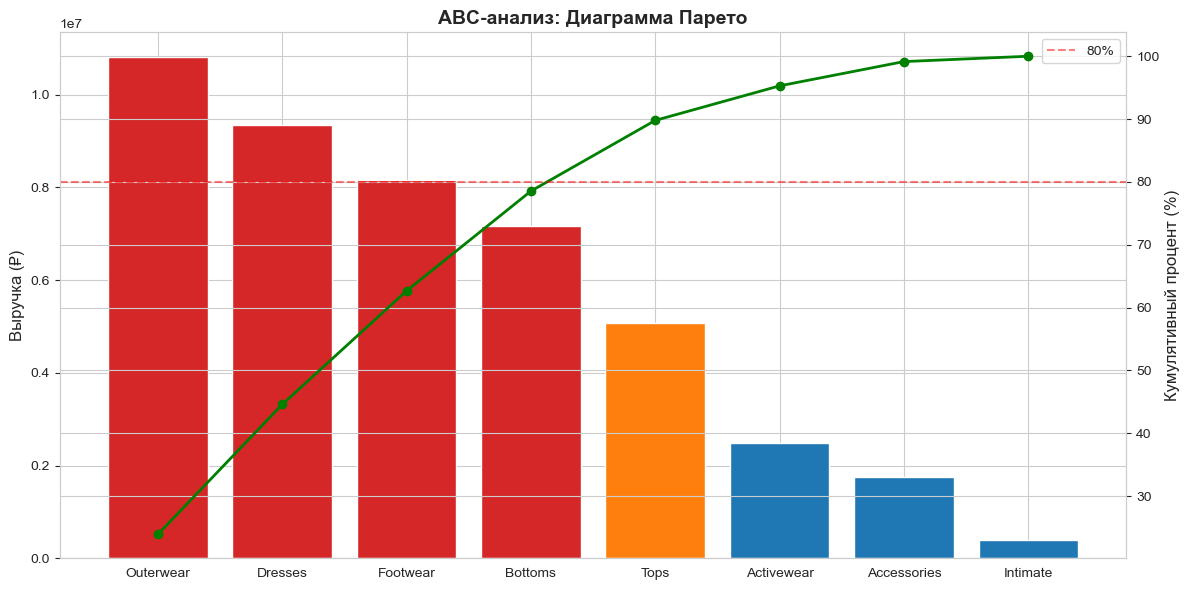

In [5]:
# визуализация (диаграмма Парето)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Столбцы выручки
ax1.bar(range(len(abc_data)), abc_data[('order_amount', 'sum')], 
        color=['#d62728' if x == 'A' else '#ff7f0e' if x == 'B' else '#1f77b4' 
               for x in abc_data['class']])
ax1.set_ylabel('Выручка (₽)', fontsize=12)

# Линия кумулятивного процента
ax2 = ax1.twinx()
ax2.plot(range(len(abc_data)), abc_data['cumulative_pct'], 'g-o', linewidth=2)
ax2.axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80%')
ax2.set_ylabel('Кумулятивный процент (%)', fontsize=12)

plt.title('ABC-анализ: Диаграмма Парето', fontsize=14, fontweight='bold')
plt.xlabel('Категория товара', fontsize=12)
plt.xticks(range(len(abc_data)), abc_data.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Категории распределились по классам следующим образом:
- **А класс**: Верхняя одежда, Платья, Обувь, Брюки
- **В класс**: Топы
- **С класс**: Спортивная одежда, Аксессуары, Нижнее белье

Рекомендации по управлению
- **A класс**: Тщательный контроль, оптимизация логистики, минимизация дефектов
- **B класс**: Стандартное управление, регулярный мониторинг
- **C класс**: Упрощенное управление, возможное исключение из линейки

---

## Этап 3: XYZ-анализ волатильности спроса

**Концепция**  
XYZ-анализ классифицирует товары по стабильности спроса:
- **X товары** (CV < 15%) - стабильный, предсказуемый спрос
- **Y товары** (CV 15-30%) - средняя волатильность спроса
- **Z товары** (CV > 30%) - высокая волатильность, непредсказуемый спрос

Коэффициент вариации (CV) = Стандартное отклонение / Среднее значение

In [6]:
# Шаг 1: Подготовка месячных данных по категориям
pivot_monthly = pd.pivot_table(
    df,
    index='year_month', 
    columns='category', 
    values='order_amount',
    aggfunc='sum'
).fillna(0)

# Шаг 2: Расчет статистики для каждой категории
xyz_data = pd.DataFrame()

for category in pivot_monthly.columns:
    sales = pivot_monthly[category]
    
    xyz_data = pd.concat([xyz_data, pd.DataFrame({
        'category': [category],
        'mean': [sales.mean()],
        'std': [sales.std()],
        'cv': [sales.std() / sales.mean() * 100 if sales.mean() != 0 else 0],
        'zero_months': [(sales == 0).sum()]  # Месяцы с нулевыми продажами
    })], ignore_index=True)

xyz_data = xyz_data.sort_values('cv', ascending=False)

# Шаг 3: Присвоение классов X/Y/Z
def assign_xyz_class(cv):
    if cv < 15:
        return 'X'
    elif cv < 30:
        return 'Y'
    else:
        return 'Z'

xyz_data['class'] = xyz_data['cv'].apply(assign_xyz_class)

# Шаг 4: Анализ характеристик
display(xyz_data)
for class_label in ['X', 'Y', 'Z']:
    class_data = xyz_data[xyz_data['class'] == class_label]
    print(f"\nКласс {class_label}:")
    print(f"  Категорий товаров: {len(class_data)}")
    print(f"  Средний CV: {class_data['cv'].mean():.1f}%")
    print(f"  Среднее кол-во месяцев с нулевой продажей: {class_data['zero_months'].mean():.1f}")

,category,mean,std,cv,zero_months,class
5,Intimate,18301.487143,8315.850639,45.438114,0,Z
1,Activewear,118237.632381,30150.541693,25.499954,0,Y
7,Tops,242017.725714,44484.050418,18.380493,0,Y
2,Bottoms,341361.443333,53439.015909,15.654672,0,Y
3,Dresses,444730.076667,69557.757170,15.640444,0,Y
6,Outerwear,514566.928571,78256.241734,15.208176,0,Y
0,Accessories,83076.744286,12021.795591,14.470711,0,X
4,Footwear,388730.209524,55332.241735,14.234099,0,X



Класс X:
  Категорий товаров: 2
  Средний CV: 14.4%
  Среднее кол-во месяцев с нулевой продажей: 0.0

Класс Y:
  Категорий товаров: 5
  Средний CV: 18.1%
  Среднее кол-во месяцев с нулевой продажей: 0.0

Класс Z:
  Категорий товаров: 1
  Средний CV: 45.4%
  Среднее кол-во месяцев с нулевой продажей: 0.0


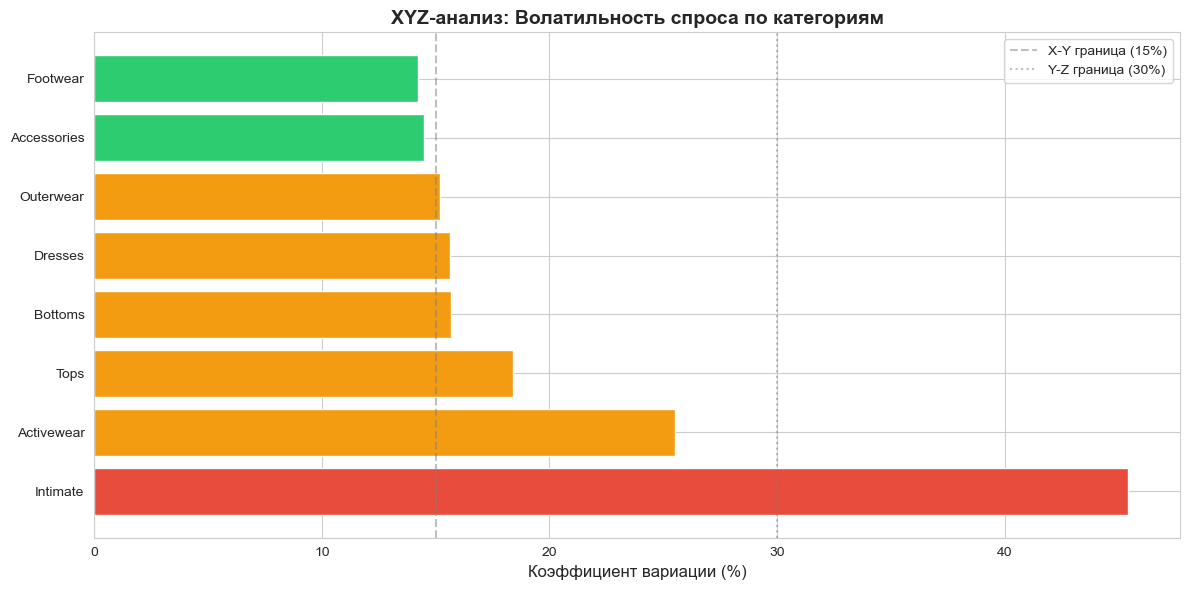

In [7]:
# визуализация
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71' if x == 'X' else '#f39c12' if x == 'Y' else '#e74c3c' 
          for x in xyz_data['class']]

bars = ax.barh(xyz_data['category'], xyz_data['cv'], color=colors)

# Добавить вертикальные линии пороговых значений
ax.axvline(x=15, color='gray', linestyle='--', alpha=0.5, label='X-Y граница (15%)')
ax.axvline(x=30, color='gray', linestyle=':', alpha=0.5, label='Y-Z граница (30%)')

ax.set_xlabel('Коэффициент вариации (%)', fontsize=12)
ax.set_title('XYZ-анализ: Волатильность спроса по категориям', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

Распределение по XYZ классам:
- **X класс**: Обувь и Аксессуары - имеют наиболее стабильный спорс.
- **Y класс**: Верхняя одежда, Платья, Брюки, Топы, Спортивная одежда
- **Z класс**: Нижнее белье

Рекомендации по управлению
- **X класс**: Стандартные запасы, предсказуемые заказы у поставщика
- **Y класс**: Повышенные запасы, страхование колебаний
- **Z класс**: Максимальные запасы, быстрые каналы поставки, гибкое управление

---

## Этап 4: Матрица ABC-XYZ (комбинированный анализ)

**Концепция**  
Комбинируем ABC и XYZ для получения матрицы 3×3 = 9 квадрантов управления:

```
             X              Y              Z
           (Stable)     (Medium)       (Volatile)
A (High)   A-X (80%)   A-Y (15%)      A-Z (5%)
B (Mid)    B-X (30%)   B-Y (50%)      B-Z (20%)
C (Low)    C-X (10%)   C-Y (40%)      C-Z (50%)
```

Распределение категорий товаров по ячейкам:
xyz_class  X  Y  Z  All
class                  
A          1  3  0    4
B          0  1  0    1
C          1  1  1    3
All        2  5  1    8

Выручка по ячейкам:
xyz_class           X            Y          Z
class                                        
A          8163334.40  27313827.42       0.00
B                0.00   5082372.24       0.00
C          1744611.63   2482990.28  384331.23


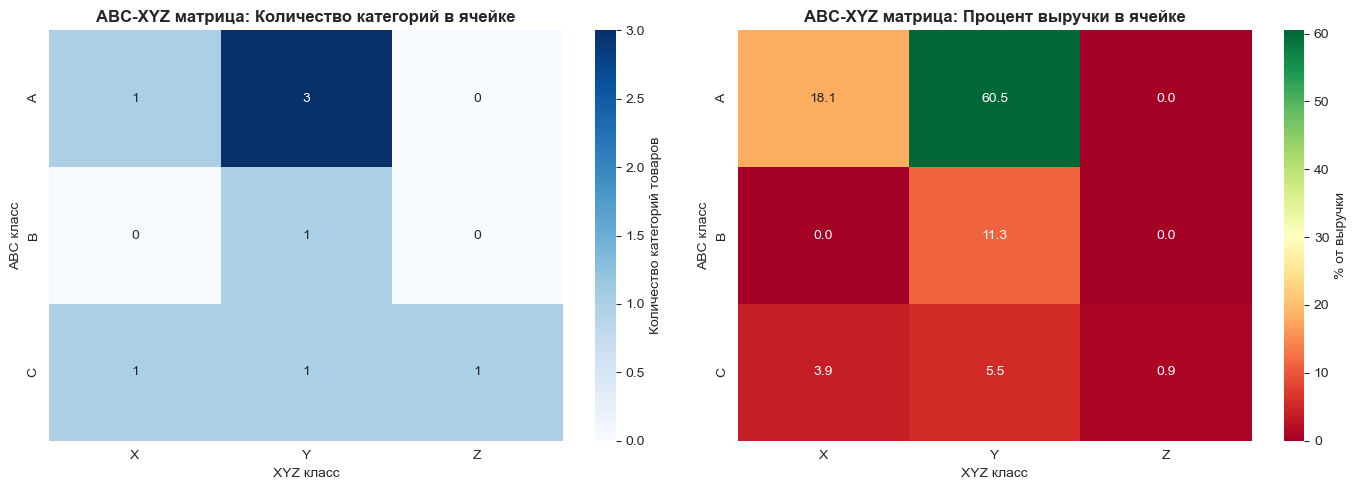


Рекомендации по управлению:

A-X: Оптимизировать: стабильные и ценные, можно снизить запасы
  Категорий товаров: 1 - Footwear
  Выручка: ₽8,163,334

A-Y: Контролировать: стоят дорого, волатильность средняя
  Категорий товаров: 3 - Outerwear, Dresses, Bottoms
  Выручка: ₽27,313,827

B-Y: Мониторить: среднего значения и волатильности
  Категорий товаров: 1 - Tops
  Выручка: ₽5,082,372

C-X: Упрощать: низкая ценность, но стабильны
  Категорий товаров: 1 - Accessories
  Выручка: ₽1,744,612

C-Y: Пересмотреть: медленно движущиеся товары
  Категорий товаров: 1 - Activewear
  Выручка: ₽2,482,990

C-Z: Исключать или перевести на предзаказ: низкая ценность и высокая волатильность
  Категорий товаров: 1 - Intimate
  Выручка: ₽384,331


In [38]:
# Шаг 1: Объединение ABC и XYZ данных
# убираю мультииндекс у колонок abc_data
abc_data.columns = ['_'.join(filter(None, col)).strip() if isinstance(col, tuple) else col for col in abc_data.columns.values]
# склеиваю две таблицы с классами
combined = abc_data.reset_index().merge(
    xyz_data[['category', 'class']].rename(columns={'class': 'xyz_class'}),
    on='category'
)
# делаю колонку объединенного класса
combined['matrix_cell'] = combined['class'] + '-' + combined['xyz_class']

# Шаг 2: Подсчет товаров в каждой ячейке матрицы
matrix = pd.crosstab(
    index=combined['class'],
    columns=combined['xyz_class'],
    margins=True
)

# Шаг 3: Матрица выручки
revenue_matrix = pd.crosstab(
    index=combined['class'],
    columns=combined['xyz_class'],
    values=combined['order_amount_sum'],
    aggfunc='sum'
).fillna(0)

print("Распределение категорий товаров по ячейкам:")
print(matrix)
print("\nВыручка по ячейкам:")
print(revenue_matrix)

# визуализация
# Матрица размера (количество категорий товаров)
size_matrix = pd.crosstab(
    index=combined['class'],
    columns=combined['xyz_class']
)

# Матрица выручки
revenue_pct_matrix = revenue_matrix.div(revenue_matrix.values.sum()) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1: Количество товаров
sns.heatmap(size_matrix, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Количество категорий товаров'})
ax1.set_title('ABC-XYZ матрица: Количество категорий в ячейке', fontweight='bold')
ax1.set_xlabel('XYZ класс')
ax1.set_ylabel('ABC класс')

# Heatmap 2: Процент выручки
sns.heatmap(revenue_pct_matrix, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2, cbar_kws={'label': '% от выручки'})
ax2.set_title('ABC-XYZ матрица: Процент выручки в ячейке', fontweight='bold')
ax2.set_xlabel('XYZ класс')
ax2.set_ylabel('ABC класс')

plt.tight_layout()
plt.show()

# Шаг 4: Рекомендации для каждой ячейки
recommendations = {
    'A-X': 'Оптимизировать: стабильные и ценные, можно снизить запасы',
    'A-Y': 'Контролировать: стоят дорого, волатильность средняя',
    'A-Z': 'Страховать: критичные товары, волатильность высокая',
    'B-X': 'Стандартное управление: достаточно предсказуемые',
    'B-Y': 'Мониторить: среднего значения и волатильности',
    'B-Z': 'Гибкое управление: возможны частые колебания',
    'C-X': 'Упрощать: низкая ценность, но стабильны',
    'C-Y': 'Пересмотреть: медленно движущиеся товары',
    'C-Z': 'Исключать или перевести на предзаказ: низкая ценность и высокая волатильность'
}

print("\nРекомендации по управлению:")
for cell, rec in recommendations.items():
    items = combined[combined['matrix_cell'] == cell]
    if len(items) > 0:
        print(f"\n{cell}: {rec}")
        print(f"  Категорий товаров: {len(items)} - {', '.join(items['category'].tolist())}")
        print(f"  Выручка: ₽{items['order_amount_sum'].sum():,.0f}")

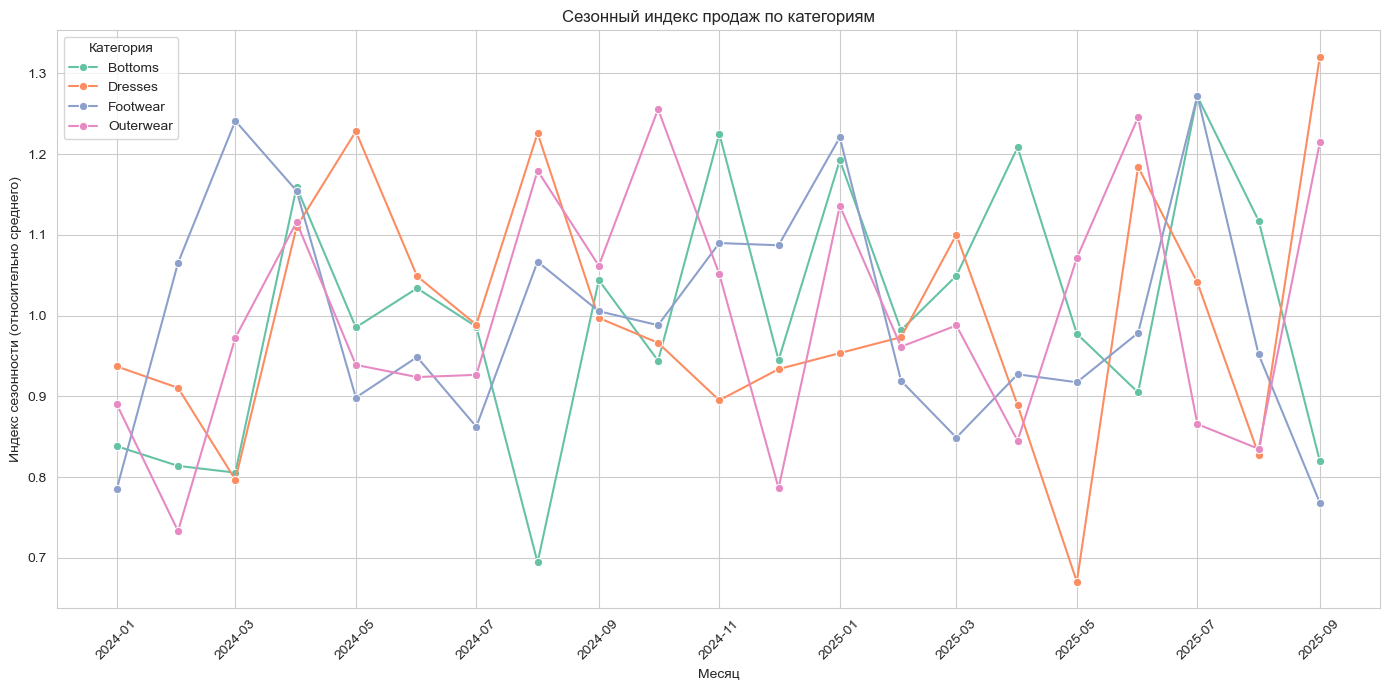

category,Accessories,Activewear,Bottoms,Dresses,Footwear,Intimate,Outerwear,Tops
year_month,,,,,,,,
1,0.861358,0.963366,1.015416,0.945391,1.003181,1.193715,1.013037,1.059429
2,0.952302,0.741405,0.898059,0.942010,0.992413,1.056395,0.847497,0.837988
3,0.920540,1.101934,0.927546,0.948578,1.045138,0.695240,0.980268,1.069947
4,1.144901,0.905732,1.183710,0.999563,1.040996,1.675736,0.980529,1.047804
5,1.091997,1.390122,0.981513,0.949305,0.908084,0.754366,1.005270,1.090359
6,0.824715,0.873660,0.969491,1.116581,0.963701,0.783042,1.084787,0.802855
7,1.013200,0.858913,1.128882,1.014909,1.067478,1.007610,0.896237,1.020904
8,1.040680,1.223131,0.906070,1.026993,1.009437,0.835394,1.007284,1.251092
9,0.985344,0.661384,0.931976,1.158957,0.886912,0.973897,1.138286,0.952511


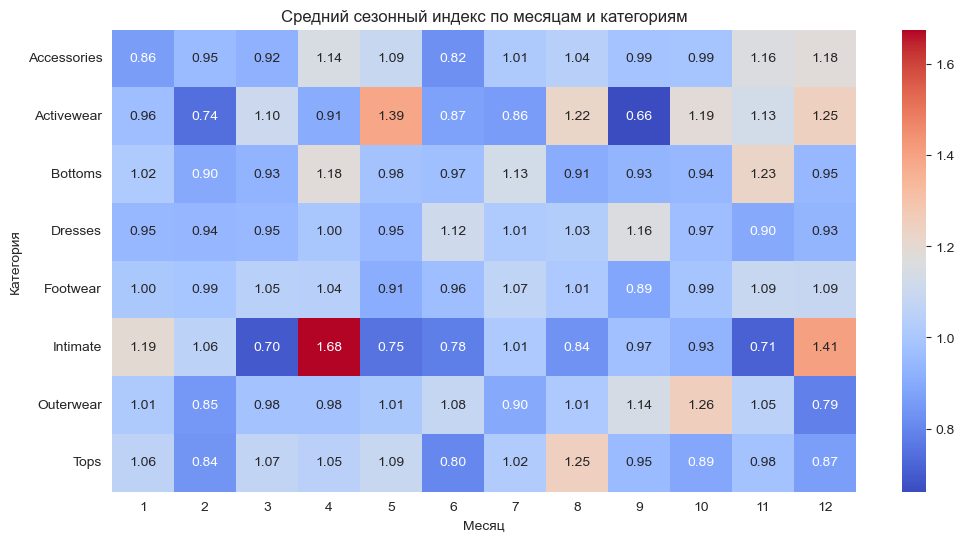

In [49]:
# Шаг 1: Группируем данные по месяцу и категории
monthly_sales = df.groupby(['year_month', 'category'])['order_amount'].sum().reset_index()

# Преобразуем period в datetime для удобства графиков и сортировки
monthly_sales['year_month'] = pd.to_datetime(monthly_sales['year_month'])

# Шаг 2: Расчет сезонного индекса (доля продаж в месяце относительно среднего)
monthly_avg = monthly_sales.groupby('category')['order_amount'].transform('mean')
monthly_sales['seasonality_index'] = monthly_sales['order_amount'] / monthly_avg

# Шаг 3: Визуализация сезонности для выбранных категорий (A-X, A-Y)
categories_to_plot = ['Footwear', 'Outerwear', 'Dresses', 'Bottoms']  

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales[monthly_sales['category'].isin(categories_to_plot)],
             x='year_month', y='seasonality_index', hue='category', marker='o')

plt.title('Сезонный индекс продаж по категориям')
plt.xlabel('Месяц')
plt.ylabel('Индекс сезонности (относительно среднего)')
plt.xticks(rotation=45)
plt.legend(title='Категория')
plt.tight_layout()
plt.show()

# Шаг 4: Вывод статистики сезонности (средние индексы по месяцам)
seasonality_summary = monthly_sales.groupby([monthly_sales['year_month'].dt.month, 'category'])['seasonality_index'].mean().unstack()
display(seasonality_summary)

# По желанию можно построить тепловую карту сезонностей
plt.figure(figsize=(12, 6))
sns.heatmap(seasonality_summary.T, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Средний сезонный индекс по месяцам и категориям')
plt.xlabel('Месяц')
plt.ylabel('Категория')
plt.show()

---

### Общие выводы  
**ABC-анализ** показал следующее распределение выручки по категориям товаров:
- `Outerwear`, `Dresses`, `Footwear`, `Bottoms` - ₽35,477,162 (78,5%) (класс А)
- `Tops`                                - ₽ 5,082,372 (11.3%) (класс В)
- `Activewear`, `Accessories`, `Intimate`     - ₽ 4,611,933 (10.2%) (класс С)

**XYZ-анализ** показал следующее распределение коэффициента вариации по категориям товаров:
- Accessories, Footwear                         - 14,4% (класс X)
- Outerwear, Dresses, Bottoms, Tops, Activewear - 18,1% (класс Y)
- Intimate                                      - 45,4% (класс Z)

Волатильность связана с непредсказуемым поведением покупателей или сезонными колебаниями.

**Совмещённый ABC-XYZ анализ** уточнил:

Товары категории `Footwear` (класс A-X) - являются приоритетными — высокая важность и стабильность спроса.

Товары категории `Intimate` (класс C-Z) — наименее выгодные с нестабильным спросом, требуют особого подхода.

**Анализ сезонности** выявил закономерные пики и спады продаж по категориям, что подтверждает сезонный характер спроса на отдельные группы товаров (например, Outerwear — зимний сезон, Accessories и Footwear — весна-лето).

### Рекомендации
Оптимизация управления запасами:

Для товаров группы A-X увеличить запасы и обеспечить бесперебойную доступность, так как они дают основной доход и имеют стабильный спрос.

Для категорий B-Y и B-Z оптимизировать запасы с учётом выявленной сезонности, снижать излишки в «низкий» сезон.

Товары C-Z рассмотреть для исключения из ассортиментной матрицы или перейти на модель предзаказа, чтобы уменьшить складские затраты и риски.

**Прогнозирование и планирование:**

Использовать сезонность и коэффициенты вариативности (XYZ) для более точного прогноза спроса, что позволит планировать закупки и маркетинговые активности.

Постоянно обновлять анализ, чтобы оперативно реагировать на изменения покупательского поведения и рынка.

Сегментация и фокус маркетинга:

Фокусироваться на продвижении товаров класса A-X с выгодными акциями и повышением лояльности.

Для товаров с сезонным спросом формировать специальные кампании в преддверии сезонов.

**Управление ассортиментом:**

Периодически пересматривать ассортимент, учитывая как важность товаров (ABC), так и их стабильность спроса (XYZ) вместе с сезонностью.

Инвестировать в товары, демонстрирующие стабильный рост и сезонный потенциал.